In this notebook, we will be trying to understand how to block the effect of noise on Images. 

### First, we will be looking at the problem of optimal transport between absolute 0 and noise:
For $\epsilon \ which \ has \ distribution \ of \ i.i.d \ (0,\sigma^2)$

$W_1(0, \epsilon)= W_1(0_+ + \epsilon_- , 0_- + \epsilon_+) = W_1(\epsilon_- , \epsilon_+) \leq f(\sigma)
$

Besides that, we would like to find the closed expression for calculating classic euclidean distance which will be an anchor for how well we do 

In [2]:
import numpy as np
import ot
import cvxpy as cp
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def plot_marginals(X, p, q, title, first_distribution_title = 'Source dist: p', second_distribution_title = 'Target dist: q'):
    """
    Plot the marginals of the transport map
    :param X: linear space in which the distributions are defined
    :param p: source distribution
    :param q: target distribution
    :param title: title of the plot
    :return: None, plot the distributions
    """
    plt.figure(figsize=(10, 4))
    plt.bar(X, p, alpha=0.5, label=first_distribution_title, width=1/len(p))
    plt.bar(X, q, alpha=0.5, label=second_distribution_title, width=1/len(q))
    plt.title(title),
    plt.legend()
    plt.show()

In [13]:
n_p = 100
noise_param = 1e-3
X = np.linspace(0,1,n_p)

p = np.zeros(n_p)
q = np.random.normal(0, noise_param, n_p)

C = calculate_costs(len(p))

<Figure size 600x600 with 0 Axes>

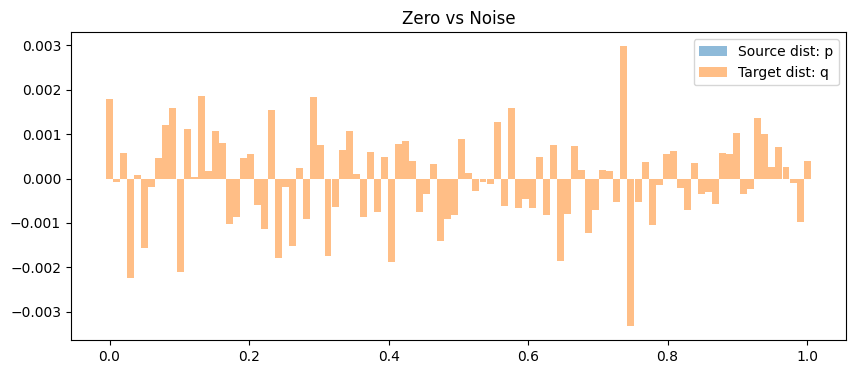

In [15]:
plt.figure(figsize=(6,6))
#TODO: add type of graph I would want in the plot_marginals function, default will be box
plot_marginals(X, p, q, 'Zero vs Noise')

<Figure size 600x600 with 0 Axes>

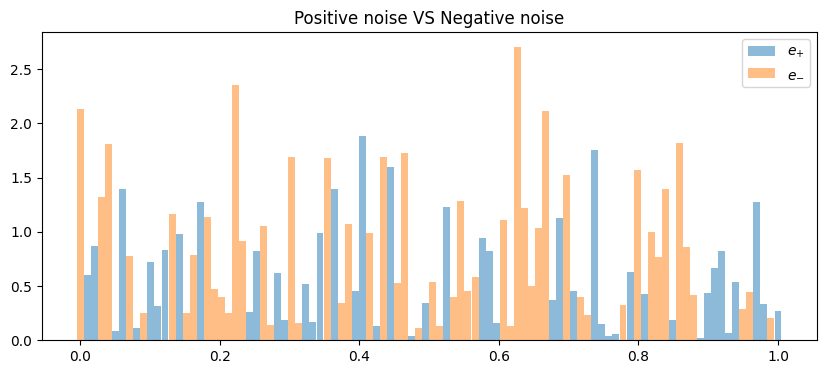

In [9]:
p_pos, p_neg = split_signed_measure(p)
q_pos, q_neg = split_signed_measure(q)

p_new = p_pos + q_neg
q_new = p_neg + q_pos

plt.figure(figsize=(6,6))
plot_marginals(X = X, p = p_new, q = q_new, title = 'Positive noise VS Negative noise', first_distribution_title=r'$e_{+}$', 
               second_distribution_title=r'$e_{-}$')

In [10]:
p_new.max()

1.882235035154665

In [14]:
q.max()

0.002980284730429745

In [21]:
C

array([[ 0,  1,  2, ..., 97, 98, 99],
       [ 1,  0,  1, ..., 96, 97, 98],
       [ 2,  1,  0, ..., 95, 96, 97],
       ...,
       [97, 96, 95, ...,  0,  1,  2],
       [98, 97, 96, ...,  1,  0,  1],
       [99, 98, 97, ...,  2,  1,  0]])

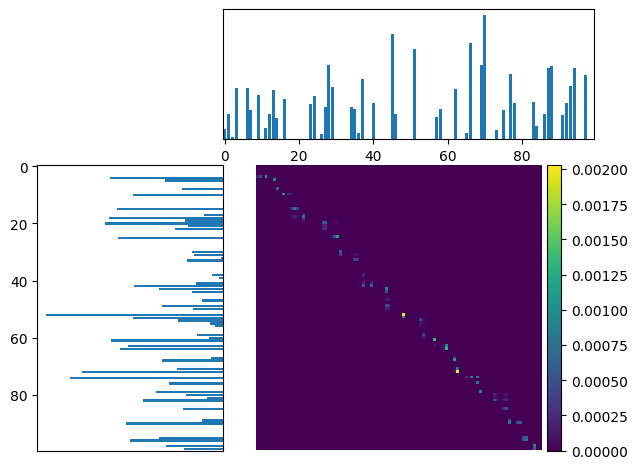

In [40]:
plan, log = ot.unbalanced.mm_unbalanced(a = p_new, b = q_new, M = C, reg_m=10, log=True)
plot_transport_map_with_marginals(p_new, q_new, plan, '')

In [61]:
a = p_new
b = q_new
M = C

@interact(reg_m=FloatSlider(min=0.5, max=10.0, step=0.1, value=10), a=fixed(a), b=fixed(b), M=fixed(M))
def interactive_UOT(reg_m=10):
    plan, log = ot.unbalanced.mm_unbalanced(a=a, b=b, M=M, reg_m=reg_m, log=True)
    fig = plot_transport_map_with_marginals(a=a,b=b,M=plan,title='interactive reg_param')
    #fig = plt.imshow(plan, cmap='gray')
    #plt.title('interactive reg_param')
    print("The sum of source distribution:", a.sum())
    print("sum of target distribution:", b.sum())
    print("sum of transport plan:", plan.sum())
    print("The cost of the transport(including divergences):", log['cost']) 
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='reg_m', max=10.0, min=0.5), Output()), _dom_classes…

In [37]:
emd_distance = plan.sum()

In [30]:
euclidean_distance = np.linalg.norm(p - q)

In [25]:
euclidean_distance

0.01011527513696417

In [38]:
emd_distance

0.040432678355846394

## Check a few transport plans simultaneously:

In [7]:
from tqdm import tqdm

n_experiments = 20
results_emd_all = [0,0,0,0,0]
results_emd_sum = [0,0,0,0,0]
results_euc_all = [0,0,0,0,0]
n_p = 100
noise_param = 1
reg_parameter = [0.5, 2, 10, 100]  #cost of creating mass

for i in tqdm(range(len(reg_parameter))):
    results_emd = []
    results_emd_s = []
    results_euc = []
    for j in range(n_experiments):
        p = np.zeros(n_p)
        q = np.random.normal(0, noise_param, n_p)

        p_pos, p_neg = split_signed_measure(p)
        q_pos, q_neg = split_signed_measure(q)

        p_new = p_pos + q_neg
        q_new = p_neg + q_pos

        plan, log = ot.unbalanced.mm_unbalanced(a = p_new, b = q_new, M = C, reg_m=reg_parameter[i], log=True)
        results_emd.append(log['cost'])
        results_emd_s.append(plan.sum())

        results_euc.append(np.linalg.norm(p-q))

    results_emd_all[i] = np.mean(results_emd)
    results_emd_sum[i] = np.mean(results_emd_s)
    results_euc_all[i] = np.mean(results_euc)

print('The average emd distance is:', results_emd_all)
print('The average euclid distance is:', results_euc_all)

100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:32<00:00,  8.07s/it]

The average emd distance is: [10.553098623221796, 35.315012947586226, 72.74122182063192, 162.08283022508732, 0]
The average euclid distance is: [9.982385810208136, 10.038449273995692, 9.704612027790999, 10.011311080685562, 0]


In [8]:
print('The average emd distance is:', results_emd_all)
print('The average sum of transport plans is:', results_emd_sum)
print('The average euclid distance is:', results_euc_all)

The average emd distance is: [10.553098623221796, 35.315012947586226, 72.74122182063192, 162.08283022508732, 0]
The average sum of transport plans is: [9.590024448288903, 24.4216206903944, 33.098160354746696, 38.813097958728214, 0]
The average euclid distance is: [9.982385810208136, 10.038449273995692, 9.704612027790999, 10.011311080685562, 0]


What would be an optimal parameter to consider? Seems like the plans which make sense are going to give us a larger distance than the euclidean one. Although, the fact that it's not strictly bigger is strange.

I don't quite understand how this happens since every emd distance in this constilation is at least as big as the euclidean distance.